In [1]:
import torch
from torch_geometric.data import Data
import numpy as np
import networkx as nx
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import matplotlib.pyplot as plt
import scipy.special as SS
import pandas as pd
import scipy.stats as SSA

In [285]:
def superspreading_T_Loc_real(T, num_fips, initials, nbi_para, pop, paras, file_path, rand_seed):
    # initialise
    Z, Zb, D, Db = paras
    l0, i0 = initials
    r, p_ts = nbi_para
    child_seeds = rand_seed.spawn(T)

    NewInf = np.zeros((num_fips, T))
    TotInf = np.zeros((num_fips, T))
    
    NewInf[l0, 0] = i0
    TotInf[:, 0] = NewInf[:, 0]

    for ti in range(T):
        print('the current simulating time', ti)
        p_ti = P_ts.iloc[ti].values[1:]
        date_parts = P_ts.iloc[ti]['Date'].split('-')
        y, m, d = date_parts
#         WN = np.load(file_path+'M_{}{}_{}.csv')
        ########################################
        M_test = np.loadtxt(file_path+'M_{}{}_{}.csv'.format(y,m,d),delimiter=',')
        M_pop = M_test/pop_sorted[None,:]
        #if there is no one go out from one site
        temp = np.sum(M_pop,axis=0)
        if np.sum(temp == 0) == 0:
            M_pop_norm = M_pop/temp[None,:]
        else:
            print('there is no one go out from one site')
            temp[temp == 0]=1
            M_pop_norm = M_pop/temp[None,:]
            M_pop_norm[:,temp == 0] = 0
        WN_small = M_pop_norm[:100,:100]
        WN = WN_small/np.sum(WN_small,axis=0)[None,:]
        ########################################
        infectors = np.int64(NewInf[:, ti])
        pop_immu = 1-TotInf[:, ti]/pop[:]
        pop_immu[pop_immu < 0] = 0
        
        rng = np.random.default_rng(child_seeds[ti])
        totoal_new_infection_loc = []
        total_new = 0
        for i in range(num_fips):
            infectors_loc_i = infectors[i]
            xx = np.arange(0, 100, 1)  # define the range of x values the
            p = p_ti[i]
            pmf = SSA.nbinom.pmf(xx, r, p)
            weights_n = pmf/np.sum(pmf)
            ttt = np.random.choice(len(weights_n), size=infectors_loc_i, p=weights_n) #np.array([2]*infectors_loc_i) # #rng
            new_array = np.round(ttt*pop_immu[i])
            if len(new_array)>0:
                print(ttt)
            new_s = np.int64(np.sum(new_array))
            
            totoal_new_infection_loc.extend([i]*new_s)
            total_new = total_new + new_s
        # to be assigned, every new infections for the infector
#         total_new = np.round(tt*immu_all)
#         totoal_new_infection_loc = get_new_infections_position(
#             infectors, total_new, num_fips)
        z_num = np.int64(total_new)
        
        NF = np.zeros((2, z_num), dtype=np.int64)
        # for the time distribution
        latency_p = SSA.gamma.rvs(a=Z, scale=Zb, size=z_num, random_state=rng)
        infectious_p = SSA.gamma.rvs(
            a=D, scale=Db, size=z_num, random_state=rng)
        v = rng.random(z_num)
        delay_days = latency_p+v*infectious_p #latency_p+v*infectious_p  # 3+5*0.5

        NF[0, :] = np.ceil(delay_days+ti)  # make it idx int
        # for the location distribution
        NF[1, :] = totoal_new_infection_loc
        df = pd.DataFrame(NF.T, columns=['time', 'o_l'])
        l_list = np.arange(num_fips)
        df['d_l'] = df['o_l'].apply(lambda x: rng.choice(l_list, size=1, p=WN[:, x])[0]) #np.random
        df = df[df['time'] <= (T-1)]
        NF_ii = np.array(df)
        for (t, o, d) in NF_ii:
            NewInf[d, t] = NewInf[d, t]+1
        TotInf = np.cumsum(NewInf, axis=1)

    return NewInf, TotInf

In [292]:
T = 10
R0_ts = pd.read_csv('df_Rmean_full.csv',index_col='Date')
R0_ts.fillna(0, inplace=True)
R0_ts_test = R0_ts.iloc[81:81+T]

pop_sorted = np.loadtxt('pop_sorted.csv')
pop_test = pop_sorted[:100]
N = pop_test.shape[0]

In [296]:
R_estimate = pd.read_csv('estimate_R0_beta.csv',index_col='Date')

In [307]:
R0_975 = pd.read_csv('df_R_975_full.csv',index_col='Date')

In [299]:
ny_1 = R_estimate.iloc[:,1824]

In [308]:
ny_2 = R0_ts.iloc[:,1824]
ny_std = R0_975.iloc[:,1824]

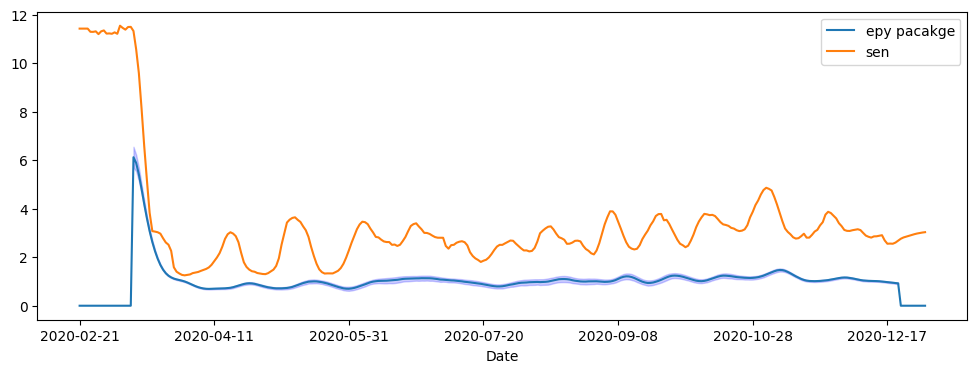

In [316]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))
ny_2[29:].plot(ax=ax,label='epy pacakge') 
ny_1.plot(ax=ax, label='sen')
ax.fill_between(ny_1.index, ny_2[29:]*2 - ny_std[29:], ny_std[29:],color='blue',alpha = 0.2)
plt.legend()

In [196]:
file_path = '/Users/qingyao/Documents/branching_data/real_data/' ##M_202003_10.csv

In [ ]:
Z = 3  # latent period
Zb = 1  # scale parameter for Z
D = 5  # infectious period
Db = 1  # scale parameter for b

In [282]:
P_ts = pd.DataFrame()
P_ts['Date'] = R0_ts_test['Date']
P_col = []
for i in range(N):
#     R_ts[str(i)+'_R_mean'] = R
    fips = R0_ts_test.columns[1+i]
    P_col.append(fips+'_p_mean')

In [283]:
r = 1
df_to_add = R0_ts_test[R0_ts_test.columns[1:].values].apply(lambda x: r/(x+r))
P_ts = pd.concat([P_ts, df_to_add], axis=1)

In [288]:
ss = np.random.SeedSequence(100)
E_NewInf_i, E_TotInf_i = superspreading_T_Loc_real(10, N, (33, 100), (r, P_ts), pop_test, (Z, Zb, D, Db), file_path, ss)
# E_NewInf_i

the current simulating time 0
[0 1 0 0 0 0 0 0 0 1 3 0 0 3 1 0 0 0 0 3 0 2 0 0 0 0 0 0 2 1 1 0 1 0 2 0 0
 0 1 1 1 0 0 0 0 0 0 0 1 0 2 0 2 0 0 0 0 1 2 0 1 0 1 0 0 4 1 1 3 1 2 0 0 0
 0 1 0 0 0 0 2 0 2 0 0 0 2 0 0 1 0 0 1 1 2 0 0 1 0 4]
the current simulating time 1
[0]
[2]
the current simulating time 2
[0]
[3 1 0]
[0]
the current simulating time 3
[2]
[1]
[0 1]
the current simulating time 4
[0 1 0 0 0]
[0 0 0 0 0 5]
the current simulating time 5
[0]
[0]
[1 3 0 0]
[0 0 0 0 0 2 0]
[0]
the current simulating time 6
[0 1 0]
[2 0 0 0]
[0]
the current simulating time 7
[0]
[0 0 2 0 2 0 0 2]
the current simulating time 8
[0 1 0]
[1 0 3 0 0 0 0 0 0]
the current simulating time 9
[1]
[0 0 2]
